# Advantage Actor Critic (A2C)

-----------
### 0. Background: From Only Actor/Critic to Actor-Critic

In [REINFORCE](../../policy-based/policy-gradient-methods/improved-reinforce/improved_reinforce.ipynb) method, we have

$$
\nabla_\theta U(\theta) \approx \hat{g} = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=0}^T \nabla_{\theta} \log \pi_{\theta}(a_t | s_t) \cdot R_t^{\text{future}} \right]
$$

and now we consider discount factor

$$
\nabla_\theta U(\theta) \approx \hat{g} = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=0}^T \nabla_{\theta} \log \pi_{\theta}(a_t | s_t) \cdot \gamma^{t} R_t^{\text{future}} \right]
$$

and convert into below form, we make $G_t = \gamma^{t} R_t^{\text{future}}$
$$
\nabla_\theta U(\theta) \approx \hat{g} = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=0}^T \nabla_{\theta} \log \pi_{\theta}(a_t | s_t) \cdot G_t \right]
$$

in REINFORCE like method, we use actual observed trajectory to compute $G_t$, however, we need to collect whole trajectory for  policy gradient $\hat{g}$.

$$
G_t = r_t + \gamma G_{t+1}
$$

in Actor-Critic method, like [SARSA](../../../model-free-learning/discrete-state-problems/temporal-difference-methods/temporal_difference_blackjack.ipynb) we take a action $a_{t+1}$ at $s_{t+1}$ but not to interact with environment and compute $G_t = r_t + \gamma Q(s_{t+1}, a_{t+1})$, here we use **Value Network** to approximate $G_{t+1}$, so we have

$$
G_t = r_t + \gamma V(s_{t+1}; \theta)
$$


$$
\nabla_\theta U(\theta) \approx \hat{g} = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=0}^T \nabla_{\theta} \log \pi_{\theta}(a_t | s_t) \cdot G_t \right]
$$

-----------

### 1. Import the Necessary Packages

In this notebook, we will implement A2C and train a policy to play [atari-pong](https://ale.farama.org/environments/pong/), using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy.


In [2]:
import numpy as np
from enum import Enum
import ale_py
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from parallel_env import ParallelEnv
from plot_utils import display_frame, save_animation, plot_scores


%matplotlib inline
gym.register_envs(ale_py)

device = torch.device("cuda:0" if torch.cuda.is_available() else 
					  "mps" if torch.backends.mps.is_available() else 
					  "cpu")
print("using device: ",device)

using device:  mps


### 2. Explore Environment

<div style="text-align: center;">
		<img src="./images/pong.gif" alt="Mountain Car Environment" width="10%">
</div>

#### Continuous State Space
- **Observation Type**: `"rgb"`
- **Observation Space**: `Box(0, 255, (210, 160, 3), np.uint8)`
	- Observations are RGB images with dimensions 210x160 and 3 color channels. The pixel values range from 0 to 255.

#### Discrete Action Space
- **Type**: `Discrete(6)`
- **Actions**:
	- `0`: `NOOP` (No operation)
	- `1`: `FIRE`
	- `2`: `RIGHT`
	- `3`: `LEFT`
	- `4`: `RIGHTFIRE`
	- `5`: `LEFTFIRE`

> To simplify training, we will only use the following two actions:
> - `4`: `RIGHTFIRE`
> - `5`: `LEFTFIRE`

The `FIRE` part ensures the game starts again after losing a life.

#### Other Settings
1. **Frameskip**
		- **Value**: `4`
		- **Explanation**: The environment executes the same action for 4 consecutive frames before observing the next state. This deterministic frameskip makes the environment faster to train compared to the vanilla `Pong-v4`, which uses a stochastic frameskip of `(2, 5)`.

2. **Repeat Action Probability**
		- **Value**: `0.0`
		- **Explanation**: This setting ensures no randomness in action repetition. The same action will always have the same effect, making the environment fully deterministic and predictable.

By using deterministic frameskip and disabling action stickiness, `PongDeterministic-v4` is more efficient for training reinforcement learning models.


In [3]:
env = gym.make('PongDeterministic-v4')

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


In [4]:
# Explore state (observation) space
print("State space:\n", env.observation_space)

# Explore action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("Shape of State space 2 samples:")
print([env.observation_space.sample().shape for _ in range(2)])

# Generate some samples from the action space
print("Action space 2 samples:")
print(np.array([env.action_space.sample() for i in range(2)]))

State space:
 Box(0, 255, (210, 160, 3), uint8)
Action space:
 Discrete(6)
--------------------------------------------------
Shape of State space 2 samples:
[(210, 160, 3), (210, 160, 3)]
Action space 2 samples:
[5 2]


In [5]:
class Action(Enum):
	NOOP = 0         # No operation
	FIRE = 1         # Fire
	RIGHT = 2        # Move right
	LEFT = 3         # Move left
	RIGHTFIRE = 4    # Move right and fire
	LEFTFIRE = 5     # Move left and fire

### 3. Preprocessing

To speed up training, we can simplify the input by cropping the images and use every other pixel

<div style="text-align: center;">
	<img src="./images/preprocess.png" alt="Mountain Car Environment" width="50%">
</div>


In [6]:
def preprocess(image, bkg_color=np.array([144, 72, 17])):
	"""
	Preprocess a single game frame by cropping, downsampling, and normalizing.

	Args:
		image (np.ndarray): The input image (game frame) as a NumPy array.
		bkg_color (np.ndarray): The RGB background color to subtract.

	Returns:
		np.ndarray: The processed image, normalized to [0, 1].
	"""
	# Crop the image to remove irrelevant parts (e.g., score and borders)
	cropped_image = image[34:-16, :]
	# Downsample the image by taking every second pixel (both rows and columns)
	downsampled_image = cropped_image[::2, ::2]
	# Subtract the background color
	adjusted_image = downsampled_image - bkg_color
	# Convert to grayscale by taking the mean across the color channels
	grayscale_image = np.mean(adjusted_image, axis=-1)
	# Normalize pixel values to the range [0, 1]
	normalized_image = grayscale_image / 255.0

	return normalized_image


def preprocess_batch(images, bkg_color=np.array([144, 72, 17])):
	"""
	Convert outputs of ParallelEnv to inputs for tensor processing.

	Args:
		images (list or np.ndarray): Batch of input images (game frames).
		bkg_color (np.ndarray): The RGB background color to subtract.
		device (str): The device to which the tensor will be moved (e.g., "cpu" or "cuda").

	Returns:
		torch.Tensor: The processed batch of images as a tensor, normalized to [0, 1].
	"""
	# Ensure images are in a NumPy array
	# shape: (time_steps, height, width, channel)
	batch_images = np.asarray(images)

	# If the input has less than 5 dimensions, expand the dimensions
	# shape: (time_steps, batch, height, width, channels)
	if len(batch_images.shape) < 5:
		batch_images = np.expand_dims(batch_images, 1)

	# Process each image in the batch using logic from the preprocess function
	# shape: (time_steps, batch, height, width, channels)
	cropped_images = batch_images[:, :, 34:-16, :, :]  # Crop the images
	downsampled_images = cropped_images[:, :, ::2, ::2, :]  # Downsample the images
	adjusted_images = downsampled_images - bkg_color  # Subtract the background color
	
	# Convert to grayscale and normalize pixel values to [0, 1]
	# shape: (time_steps, batch, height, width)
	grayscale_images = np.mean(adjusted_images, axis=-1)  
	normalized_images = grayscale_images / 255.0

	# Rearrange the batch dimension to match the expected input format
	# shape: (batch, time_steps, height, width) or in other way
	#        (batch, channel, height, width)
	batch_input = torch.from_numpy(normalized_images).float()
	batch_input = batch_input.permute(1, 0, 2, 3)
	return batch_input


Original Frame Shape: (210, 160, 3)
Processed Frame Shape: (80, 80)


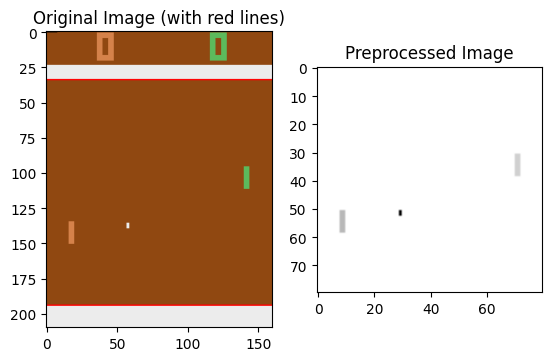

In [ ]:
# Test: get 20-th frame
env.reset()
for _ in range(20):
	action = 1 # fire
	frame, *_ = env.step(action)

processed_frame = preprocess(frame)

display_frame(frame, processed_frame)

### 4. Shared Architecture

In this implementation, we define both the Actor and Critic networks, which share a common feature extraction backbone. This design is inspired by the architecture of the [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf), where convolutional layers are used to process raw pixel inputs for reinforcement learning tasks. However, we adapt and modify the network architecture to suit the Actor-Critic framework and the specific requirements of our problem.

#### Action-Value Network in DQN
In DQN, a single network is used to estimate the action-value function $Q(s, a)$, where $s$ represents the state and $a$ represents the action. The network processes raw pixel inputs through convolutional layers, followed by fully connected layers, to output a value for each possible action.

<div style="text-align: center;">
<img src="./images/dqn-network.png" alt="DQN Network Architecture" width="50%">
</div>

#### Shared Feature Extraction Backbone for Actor and Critic
In the Actor-Critic framework, we require two separate outputs:
1. **Actor**: Outputs a probability distribution over actions (policy).
2. **Critic**: Outputs a scalar value representing the estimated value of the current state.

To achieve this, we use a shared feature extraction backbone consisting of convolutional layers and an intermediate fully connected layer. This shared backbone processes the raw pixel inputs (stacked frames) and extracts meaningful features that are used by both the Actor and Critic networks. 

This shared architecture offers several advantages:
- **Reduced Computational Redundancy**: Both networks use the same extracted features, avoiding duplicate computation.
- **Improved Learning Efficiency**: Sharing features ensures that both networks benefit from the same learned representations, leading to better coordination between the Actor and Critic.
- **Simplified Design**: A unified backbone makes the architecture modular and easier to manage.

#### Architecture Overview
The shared feature extraction backbone consists of:
- **Convolutional Layers**: These layers reduce the spatial dimensions of the input while capturing spatial and temporal dependencies in the stacked frames.
- **Intermediate Fully Connected Layer**: This layer transforms the extracted spatial features into a compact representation suitable for the Actor and Critic outputs.

The Actor and Critic networks then use this shared representation to produce their respective outputs:
- **Actor**: A fully connected layer maps the shared representation to action logits, which are converted into probabilities using a softmax or categorical distribution.
- **Critic**: A fully connected layer maps the shared representation to a single scalar value representing the state value $V(s)$.

This modular design ensures that the Actor and Critic networks are tightly coupled and learn from the same extracted features, improving the stability and efficiency of training.



### 5. Define Actor Network

- Actor Network
	- input is the stack of two different frames (which captures the movement)
	- output is number of actions, each neuron represent probability of eachf action, such as,  $P_{\rm right}$, $P_{\rm left}$

<div style="text-align: center;">
		<img src="./images/policy-network.png" alt="Mountain Car Environment" width="60%">
</div>


In [13]:
class SharedFeatureExtractor(nn.Module):
	"""
	Shared feature extraction network for both Actor and Critic.
	"""
	def __init__(self):
		super(SharedFeatureExtractor, self).__init__()
		
		# Convolutional layers
		self.conv1 = nn.Conv2d(2, 32, kernel_size=4, stride=4)  # 80x80x2 -> 20x20x32
		self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)  # 20x20x32 -> 9x9x64
		self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)  # 9x9x64 -> 7x7x64
		
		# Flattened size after convolutional layers
		self.size = 7 * 7 * 64

		# Fully connected layer for feature extraction
		self.fc = nn.Linear(self.size, 128)  # 7x7x64 -> 128

	def forward(self, x):
		# Pass through convolutional layers with ReLU activation
		x = F.relu(self.conv1(x))
		x = F.relu(self.conv2(x))
		x = F.relu(self.conv3(x))
		
		# Flatten the tensor
		x = x.view(-1, self.size)
		
		# Pass through the fully connected layer
		x = F.relu(self.fc(x))
		
		return x

In [14]:
class Actor(nn.Module):

	def __init__(self, shared_extractor):
		super(Actor, self).__init__()
		
		self.RIGHTFIRE = Action.RIGHTFIRE.value
		self.LEFTFIRE = Action.LEFTFIRE.value

		self.shared_extractor = shared_extractor
		self.fc_actor = nn.Linear(128, 2)  # Output layer for action probabilities
		
	def forward(self, x):
		# Extract shared features
		features = self.shared_extractor(x)
		
		# Get action logits
		logits = self.fc_actor(features)
		return logits

	@torch.no_grad()
	def select_action(self, frames, mode='inference'):
		"""
		Select actions based on policy for either inference or trajectory collection.
		
		Args:
			frames: Tuple of (frame1, frame2) or preprocessed tensor
			mode: Either 'inference' for single action or 'collect' for trajectory collection
			
		Returns:
			For mode='inference': single action value
			For mode='collect': tuple of (states, actions, action_probs)
		"""
		# Ensure frames are on the correct device
		if isinstance(frames, tuple):
			states = preprocess_batch(frames).to(next(self.parameters()).device)
		else:
			states = frames.to(next(self.parameters()).device)
		
		# Get action probabilities
		logits = self(states)
		dist = torch.distributions.Categorical(logits=logits)
		
		if mode == 'inference':
			# Single instance inference
			action = dist.sample().item()
			return action

		elif mode == 'collect':            
			# Select actions for Batch trajectory
			actions = dist.sample()
			
			# Calculate action probabilities
			action_probs = dist.log_prob(actions)
			
			return states, actions, action_probs
		
		else:
			raise ValueError(f"Unknown mode: {mode}. Use 'inference' or 'collect'")

	def get_action_probs(self, states, actions):
		"""
		Get probabilities for given states and actions.
		Useful for calculating policy gradients.
		
		Args:
			states: Preprocessed state tensor
			actions: Tensor of actions taken
			
		Returns:
			Tensor of action probabilities
		"""
		logits = self(states)
		dist = torch.distributions.Categorical(logits=logits)
		action_probs = dist.log_prob(actions)

		return action_probs
		
shared_extractor = SharedFeatureExtractor()
actor = Actor(shared_extractor).to(device)
print("Network:\n", actor)

# Test the forward function
print("Testing forward pass...")
dummy_input = torch.randn(1, 2, 80, 80).to(device)
logits = actor(dummy_input)
print(f"Output logits from forward pass: {logits}")

# Test the select_action function
print("\nTesting select_action...")
action = actor.select_action(dummy_input, mode='inference')
print(f"Selected action (inference mode): {action}")

# Test the get_action_probs function
print("\nTesting get_action_probs...")
actions = torch.tensor([0]).to(device)  # Example action tensor (assuming action space is [0, 1])
action_probs = actor.get_action_probs(dummy_input, actions)
print(f"Log probabilities of the actions: {action_probs}")


Network:
 Actor(
  (shared_extractor): SharedFeatureExtractor(
    (conv1): Conv2d(2, 32, kernel_size=(4, 4), stride=(4, 4))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (fc): Linear(in_features=3136, out_features=128, bias=True)
  )
  (fc_actor): Linear(in_features=128, out_features=2, bias=True)
)
Testing forward pass...
Output logits from forward pass: tensor([[-0.0426,  0.1012]], device='mps:0', grad_fn=<LinearBackward0>)

Testing select_action...
Selected action (inference mode): 1

Testing get_action_probs...
Log probabilities of the actions: tensor([-0.7676], device='mps:0', grad_fn=<SqueezeBackward1>)


### 5. Define Critic Network

- **Purpose**: The Critic network is used to estimate the value of a given state, which is a scalar representing the expected cumulative reward starting from that state. It helps in guiding the Actor's updates during training by providing a baseline to calculate the advantage function.

- **Input**: The input to the Critic network is a stack of two different frames (just like the Policy network). These frames capture the movement in the environment to provide temporal information.

- **Output**: The output of the Critic network is a single scalar value, $V(s)$, which represents the value of the input state $s$.

<div style="text-align: center;">
<img src="./images/value-network.png" alt="Critic Network Diagram" width="60%">
</div>


In [15]:
class Critic(nn.Module):
    """
    Critic network for value estimation.
    """
    def __init__(self, shared_extractor):
        super(Critic, self).__init__()
        self.shared_extractor = shared_extractor
        self.fc_critic = nn.Linear(128, 1)  # Output layer for state value

    def forward(self, x):
        # Extract shared features
        features = self.shared_extractor(x)
        
        # Get state value
        value = self.fc_critic(features)
        return value


# Instantiate shared feature extractor
shared_extractor = SharedFeatureExtractor()

# Instantiate Critic network
critic = Critic(shared_extractor).to(device)

# Test the Critic network
dummy_input = torch.randn(1, 2, 80, 80).to(device)
value = critic(dummy_input)
print(f"Critic output value: {value}")

Critic output value: tensor([[0.0095]], device='mps:0', grad_fn=<LinearBackward0>)
